In [5]:
# import the required libraries
import glob
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import torchvision
import torch.optim as optim
import torch.nn as nn

import math
from torch.utils.data import Dataset, DataLoader
import torch
from torchvision import transforms, utils
import cv2
import json
from sklearn.model_selection import train_test_split

In [6]:
from train.loader import Normalize, Rescale, RandomRotation, RandomTranslation, RandomCrop, ToTensor

In [7]:
data_path = "train/all_data.json"
with open(data_path) as f:
    d = json.load(f)

In [8]:
imgs_path_all = []
keypoints_all = []
for i in range(5000):
    imgs_path_all.append(os.path.join("train", "images", d[str(i)]['file_name']))
    keypoints_all.append(d[str(i)]['face_landmarks'])

In [9]:
mean_kpts = np.mean(np.array(keypoints_all))
std_kpts = np.std(np.array(keypoints_all))
print(mean_kpts)
print(std_kpts)

285.1921855457837
76.80763153436327


In [39]:
imgs_path_train, keypoints_train = imgs_path_all[:-400], keypoints_all[:-400]
imgs_path_val, keypoints_val = imgs_path_all[-400:-16], keypoints_all[-400:-16]
imgs_path_test, keypoints_test = imgs_path_all[-16:], keypoints_all[-16:]

In [40]:
print(len(imgs_path_train))
print(len(imgs_path_val))
print(len(imgs_path_test))

4600
384
16


In [41]:
def show_keypoints(image, keypoints):
    plt.imshow(image)
    plt.scatter(keypoints[:, 0], keypoints[:, 1], s=20, marker='.', c='m')

In [42]:
class FacialKeypointsDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, imgs_path, keypoints, transform=None):
        """
        Args:
            imgs (string): path to images
            landmarks (list of list): labels
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.imgs_path = imgs_path
        self.keypoints = keypoints
        self.transform = transform

    def __len__(self):
        return len(self.imgs_path)

    def __getitem__(self, idx):
        
        image = mpimg.imread(self.imgs_path[idx])
        sample = {'image': image, 'keypoints': np.array(self.keypoints[idx])}

        if self.transform:
            sample = self.transform(sample)

        return sample

In [43]:
data = FacialKeypointsDataset(imgs_path_train, keypoints_train)
img1 = data[0]
img2 = data[1]

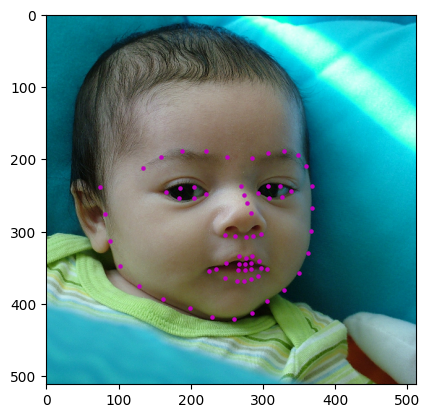

In [44]:
show_keypoints(img1['image'], img1['keypoints'])

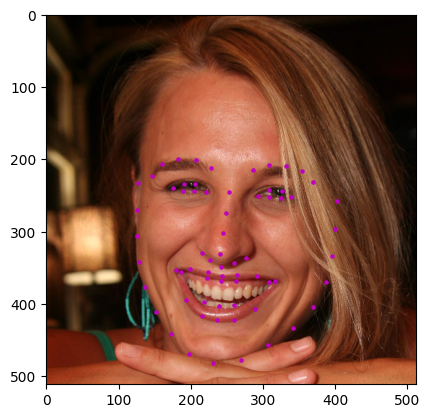

In [45]:
show_keypoints(img2['image'], img2['keypoints'])

In [46]:
rescale = Rescale(100)
rotate = RandomRotation(180, 1.0)
translate = RandomTranslation((0.2,0.2), 1.0)
composed = transforms.Compose([RandomRotation(180, 1.0), RandomTranslation((0.2,0.2), 1.0)])

(100, 100, 3)
(512, 512, 3)
(512, 512, 3)
(512, 512, 3)


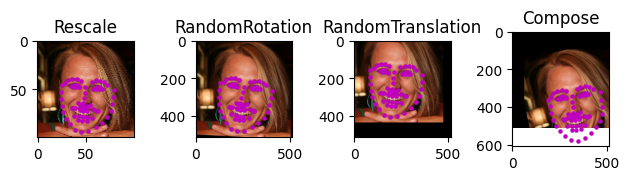

In [47]:
sample = data[1]
fig = plt.figure()
for i, tx in enumerate([rescale, rotate, translate, composed]):
    transformed_sample = tx(sample)
    
    print(transformed_sample['image'].shape)

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title(type(tx).__name__)
    show_keypoints(transformed_sample['image'], transformed_sample['keypoints'])

plt.show()

In [48]:
data_transform = transforms.Compose([Rescale(512),
                                     RandomRotation(10, 0.5),
                                     RandomTranslation((0.2,0.2), 0.5),
                                     Normalize(mean_kpts, std_kpts),
                                     ToTensor()])

data_transform_test = transforms.Compose([Rescale(512),
                                    Normalize(mean_kpts, std_kpts),
                                     ToTensor()])

# create the transformed dataset
train_dataset = FacialKeypointsDataset(imgs_path_train, keypoints_train,
                                             transform=data_transform)
val_dataset = FacialKeypointsDataset(imgs_path_val, keypoints_val,
                                             transform=data_transform)
test_dataset = FacialKeypointsDataset(imgs_path_test, keypoints_test, transform=data_transform_test)

In [49]:
model = torchvision.models.resnet18(pretrained=True)

model.fc = torch.nn.Linear(model.fc.in_features, 68*2)

model = model.type(torch.FloatTensor)
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
net = model.to(device)

In [50]:
batch_size = 16

train_loader = DataLoader(train_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=4)
val_loader = DataLoader(val_dataset,
                       batch_size=batch_size,
                       shuffle=True,
                       num_workers=4)
test_loader = DataLoader(test_dataset, 
                          batch_size=batch_size,
                          shuffle=False, 
                          num_workers=4)

In [51]:
# test the model on a batch of test images
def net_sample_output():
    
    # iterate through the test dataset
    for i, sample in enumerate(test_loader):
        
        # get sample data: images and ground truth keypoints
        images = sample['image']
        key_pts = sample['keypoints']

        # convert images to FloatTensors
        images = images.type(torch.FloatTensor).to(device)

        # forward pass to get net output
        output_pts = net(images)
        
        # reshape to batch_size x 68 x 2 pts
        output_pts = output_pts.view(output_pts.size()[0], 68, -1)
        
        # break after first image is tested
        if i == 0:
            return images.cpu(), output_pts.cpu(), key_pts

In [52]:
def show_all_keypoints(image, predicted_key_pts, gt_pts=None):
    """Show image with predicted keypoints"""
    
    # image is grayscale
    plt.imshow(image)
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='m')
    # plot ground truth points as green pts
    if gt_pts is not None:
        plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=20, marker='.', c='g')

In [53]:
# visualize the output
def visualize_output(test_images, test_outputs, gt_pts=None, batch_size=10):

    for i in range(batch_size):
        plt.figure(figsize=(20,10))
        ax = plt.subplot(1, batch_size, i+1)

        # un-transform the image data
        image = test_images[i].data   # get the image from it's Variable wrapper
        image = image.numpy()   # convert to numpy array from a Tensor
        image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image
        # un-transform the predicted key_pts data
        predicted_key_pts = test_outputs[i].data
        predicted_key_pts = predicted_key_pts.numpy()
        # undo normalization of keypoints  
        predicted_key_pts = predicted_key_pts*std_kpts+mean_kpts
        
        # plot ground truth points for comparison, if they exist
        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i]         
            ground_truth_pts = ground_truth_pts*std_kpts+mean_kpts
        
        # call show_all_keypoints
        show_all_keypoints(np.squeeze(image), predicted_key_pts, ground_truth_pts)
            
        plt.axis('off')

    plt.show()

In [54]:
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr = 0.001)

In [55]:
def train_net(n_epochs):

    # prepare the net for training
    training_loss = []

    for epoch in range(n_epochs):  # loop over the dataset multiple times
        
        train_loss = 0.0
        train_loss_total = 0.0
        net.train()

        # train on batches of data, assumes you already have train_loader
        for batch_i, data in enumerate(train_loader):
            # get the input images and their corresponding labels
            images = data['image']
            key_pts = data['keypoints']

            # flatten pts
            key_pts = key_pts.view(key_pts.size(0), -1)

            # convert variables to floats for regression loss
            key_pts = key_pts.type(torch.FloatTensor).to('cuda')
            images = images.type(torch.FloatTensor).to('cuda')

            # forward pass to get outputs
            output_pts = net(images)

            # calculate the loss between predicted and target keypoints
            loss = criterion(output_pts, key_pts)

            # zero the parameter (weight) gradients
            optimizer.zero_grad()
            
            # backward pass to calculate the weight gradients
            loss.backward()

            # update the weights
            optimizer.step()

            # print loss statistics
            train_loss += loss.item()
            train_loss_total += loss.item()
            last_batch = batch_i+1
            if batch_i % 10 == 9:    # print every 10 batches
                print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1, batch_i+1, train_loss/10))
                train_loss = 0.0
            del images
            del key_pts
            torch.cuda.empty_cache()
                
        training_loss.append(train_loss_total/last_batch)
                
        model.eval()
        val_loss = 0.0
        total = 0
        with torch.no_grad():
            for batch_i, data in enumerate(val_loader):
                # get the input images and their corresponding labels
                images = data['image']
                key_pts = data['keypoints']

                # flatten pts
                key_pts = key_pts.view(key_pts.size(0), -1)

                # convert variables to floats for regression loss
                key_pts = key_pts.type(torch.FloatTensor).to('cuda')
                images = images.type(torch.FloatTensor).to('cuda')

                # forward pass to get outputs
                output_pts = net(images)

                # calculate the loss between predicted and target keypoints
                loss = criterion(output_pts, key_pts)

                # print loss statistics
                val_loss += loss.item()
                total += 1
                
                del images
                del key_pts
                torch.cuda.empty_cache()
            print('Epoch: {}, Val Avg. Loss: {}'.format(epoch + 1, val_loss/total))


    print('Finished Training')
    return training_loss

In [ ]:
train_net(3)

Epoch: 1, Batch: 10, Avg. Loss: 0.5447368741035461
Epoch: 1, Batch: 20, Avg. Loss: 0.25682924687862396
Epoch: 1, Batch: 30, Avg. Loss: 0.14750715345144272
Epoch: 1, Batch: 40, Avg. Loss: 0.10534633621573448
Epoch: 1, Batch: 50, Avg. Loss: 0.11075963750481606
Epoch: 1, Batch: 60, Avg. Loss: 0.12235850021243096
Epoch: 1, Batch: 70, Avg. Loss: 0.09167155511677265
Epoch: 1, Batch: 80, Avg. Loss: 0.11489267498254777
Epoch: 1, Batch: 90, Avg. Loss: 0.09215986356139183
Epoch: 1, Batch: 100, Avg. Loss: 0.12766766548156738
Epoch: 1, Batch: 110, Avg. Loss: 0.12540332674980165


In [ ]:
test_images, test_outputs, gt_pts = net_sample_output()
visualize_output(test_images, test_outputs, gt_pts)

In [ ]:
## change the name to something uniqe for each new model
model_dir = 'saved_models/'
model_name = 'resnet18_pretrain_model2.pt'

# after training, save your model parameters in the dir 'saved_models'
torch.save(net.state_dict(), model_dir+model_name)